In [1]:
!pip install tf-nightly-gpu

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:35_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.relgpu_drvr445TC445_37.28845127_0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import sklearn.metrics
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.5.0-dev20201111


In [5]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [6]:
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Data preprocessing

### Data download

In [7]:
_URL = 'https://people.csail.mit.edu/celiu/CVPR2010/FMD/FMD.zip'
path_to_zip = tf.keras.utils.get_file('FMD.zip', origin=_URL, extract=True)
data_dir = os.path.join(os.path.dirname(path_to_zip), 'image')


batch_size = 8
img_height = 384
img_width = 512

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 700 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 300 files for validation.


Print all the classes

In [10]:
class_names = train_ds.class_names
print(class_names)

['fabric', 'foliage', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'water', 'wood']


Show the first 9 images and labels from the training set

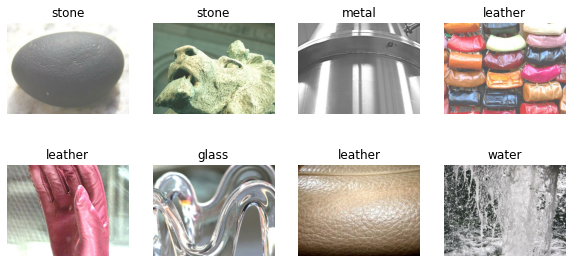

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [12]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

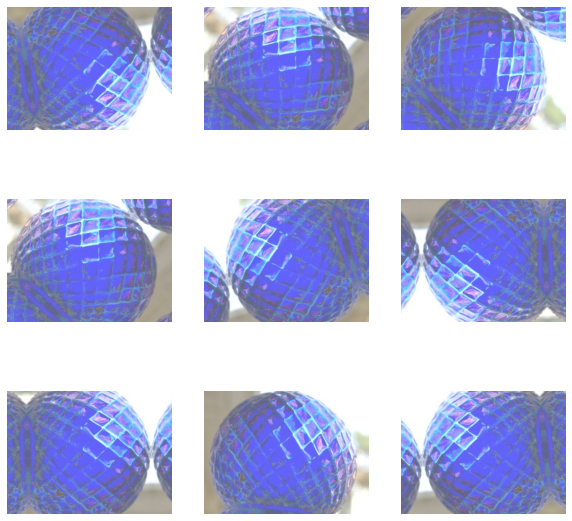

In [15]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

The model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`.To rescale them, use the preprocessing method included with the model.

In [16]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [17]:
IMG_SHAPE = (img_height, img_width , 3) 
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [18]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 12, 16, 512)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. VGG16 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [19]:
base_model.trainable = False

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 384, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 96, 128, 128)      0     

### Add a classification head

To generate predictions from the block of features, average over the spatial 12x16 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 512-element vector per image.

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 512)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value.

In [22]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 10)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [23]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a sparse categorical cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 384, 512, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 384, 512, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 384, 512, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 12, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

The 14M parameters in VGG16 are frozen, but there are 5.1K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [26]:
len(model.trainable_variables)

6

### Train the model
train for 10 epochs


In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

31/31 [==============================] - 14s 223ms/step - loss: 4.4116 - accuracy: 0.0498


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.27
initial accuracy: 0.06


In [29]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
88/88 [==============================] - 18s 189ms/step - loss: 3.7384 - accuracy: 0.1700 - val_loss: 1.7877 - val_accuracy: 0.3934
Epoch 2/10
88/88 [==============================] - 18s 203ms/step - loss: 2.4695 - accuracy: 0.3343 - val_loss: 1.2797 - val_accuracy: 0.5779
Epoch 3/10
88/88 [==============================] - 17s 199ms/step - loss: 2.0372 - accuracy: 0.4186 - val_loss: 1.0576 - val_accuracy: 0.6844
Epoch 4/10
88/88 [==============================] - 17s 191ms/step - loss: 1.7050 - accuracy: 0.4957 - val_loss: 0.9733 - val_accuracy: 0.7336
Epoch 5/10
88/88 [==============================] - 16s 184ms/step - loss: 1.4650 - accuracy: 0.5529 - val_loss: 0.9005 - val_accuracy: 0.7664
Epoch 6/10
88/88 [==============================] - 16s 185ms/step - loss: 1.4734 - accuracy: 0.5329 - val_loss: 0.8663 - val_accuracy: 0.7418
Epoch 7/10
88/88 [==============================] - 16s 185ms/step - loss: 1.2841 - accuracy: 0.6100 - val_loss: 0.8233 - val_accuracy: 0.7500

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the VGG16 base model as a fixed feature extractor.

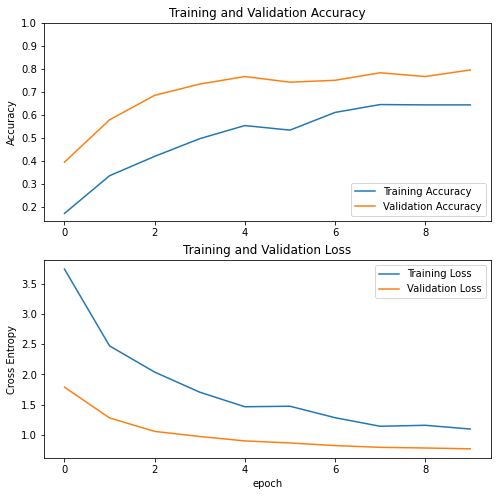

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an VGG16 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole VGG19 model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

All you need to do is unfreeze the `base_model`. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [31]:
base_model.trainable = True

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [33]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 384, 512, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 384, 512, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 384, 512, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 12, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [35]:
len(model.trainable_variables)

26

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [36]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/40
88/88 [==============================] - 37s 388ms/step - loss: 1.1141 - accuracy: 0.6372 - val_loss: 0.8231 - val_accuracy: 0.7541
Epoch 11/40
88/88 [==============================] - 32s 367ms/step - loss: 0.9766 - accuracy: 0.6767 - val_loss: 0.8467 - val_accuracy: 0.7582
Epoch 12/40
88/88 [==============================] - 30s 342ms/step - loss: 0.8335 - accuracy: 0.7097 - val_loss: 0.7913 - val_accuracy: 0.7828
Epoch 13/40
88/88 [==============================] - 30s 343ms/step - loss: 0.7883 - accuracy: 0.7311 - val_loss: 0.8481 - val_accuracy: 0.7500
Epoch 14/40
88/88 [==============================] - 30s 343ms/step - loss: 0.6980 - accuracy: 0.7584 - val_loss: 1.1296 - val_accuracy: 0.7008
Epoch 15/40
88/88 [==============================] - 30s 343ms/step - loss: 0.8189 - accuracy: 0.7457 - val_loss: 0.9723 - val_accuracy: 0.7131
Epoch 16/40
88/88 [==============================] - 30s 343ms/step - loss: 0.7520 - accuracy: 0.7400 - val_loss: 0.8953 - val_accuracy:

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

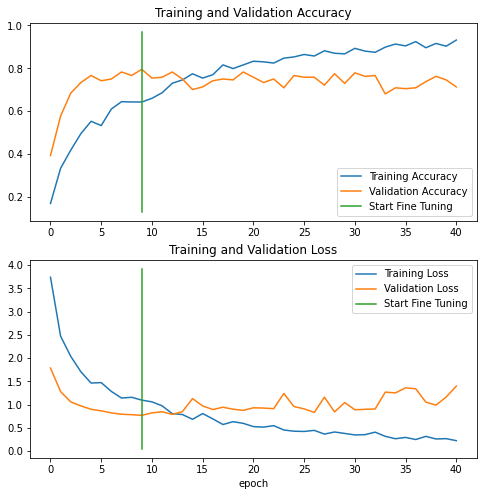

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
#pip install -q pyyaml h5py

In [40]:
model.save_weights('./my_checkpoint')

Predictions:
 [4 5 4 5 2 5 9 9]
Labels:
 [4 5 4 5 2 4 9 9]


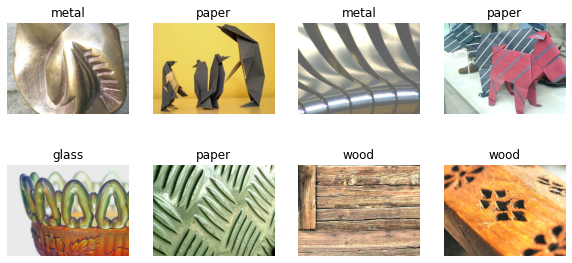

In [41]:
#Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = np.argmax(predictions, axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(batch_size):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [42]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

7/7 [==============================] - 1s 125ms/step - loss: 1.3930 - accuracy: 0.6964
Test accuracy : 0.6964285969734192


In [43]:
test_pred_raw = model.predict(test_ds)
test_pred = np.argmax(test_pred_raw, axis=1)

test_labels = np.concatenate([y for x, y in test_ds], axis=0)
# Calculate the confusion matrix.
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
# Log the confusion matrix as an image summary.
print(cm)

[[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 1 0 0 0 0 0]
 [0 0 1 2 1 0 0 1 0 0]
 [0 0 0 1 5 1 1 0 0 0]
 [0 0 0 0 2 5 0 0 0 0]
 [0 0 1 0 2 0 6 0 0 0]
 [0 0 0 0 1 0 0 1 0 1]
 [0 0 1 0 1 0 0 0 4 0]
 [0 0 0 0 1 0 0 0 0 5]]


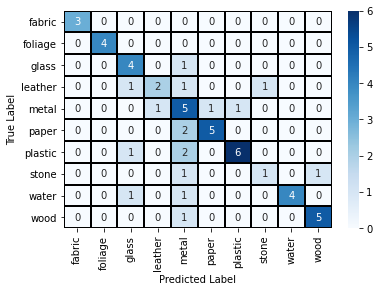

In [44]:
fig = sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = class_names , yticklabels = class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show(fig)